<a href="https://colab.research.google.com/github/KunXie/myColab/blob/master/Time_Series_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References: https://courses.analyticsvidhya.com/courses/creating-time-series-forecast-using-python/

# Time Series Forecasting using Python
## Introduction to Time Series

Definition: A series of data points collected in time order is known as a time series. 数值必须与时间有关。

Be able to differentiate between a Time Series and a non Time Series data

## Components of a Time Series

1. **Trend**: Trend is a general direction in which something is developing or changing.

2. **Seasonality**: the pattern is repeating at regular time interval

Difference between a time series and regression problem:
* a time series is time dependent but the basic assumption of a linear regression model that the observations are independent
* most Time Series have some form of seasonality trends

predicting a time series using regression techniques is not a good approach

## Problem Statements

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

### Understanding Data:

1) Hypothesis Generation

**Hypothesis Generation** is the process of listing out all the possible factors that can affect the outcome.

Hypothesis generation is done before having a look at the data in order to avoid any bias that may result after the observation.

下面是作者的一些假设：
1. There will be an increase in the traffic as the years pass by.
2. The traffic will be high from May to October.
3. Traffic on weekdays will be more as compared to weekends/holidays.
4. Traffic during the peak hours will be high.

2) Getting the system ready and loading the data




In [0]:
import pandas as pd          
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                  # To ignore the warnings warnings.filterwarnings("ignore")

# read the train and test data
# using github if file < 25 MB

test_url = 'https://raw.githubusercontent.com/KunXie/myColab/master/dataset/Test_0qrQsBZ.csv'
train_url = 'https://raw.githubusercontent.com/KunXie/myColab/master/dataset/Train_SU63ISt.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# make a copy in order not to alter the original dataset
train_original=train.copy() 
test_original=test.copy()

3) Dataset Structure and Content


In [2]:
# ID is the unique number given to each observation point.
# Datetime is the time of each observation.
# Count is the passenger count corresponding to each Datetime.

train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [3]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [4]:
train.shape, test.shape

((18288, 3), (5112, 2))

4) Feature Extraction

extract the time and date from the Datetime

In [0]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')

test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')

In [0]:
# 这里可以用XXX库
# some hypothesis for the effect of hour, day, month and year on the passenger count. so extract them
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

# assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

train['day of week'] = train['Datetime'].dt.dayofweek 
temp = train['Datetime']

temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


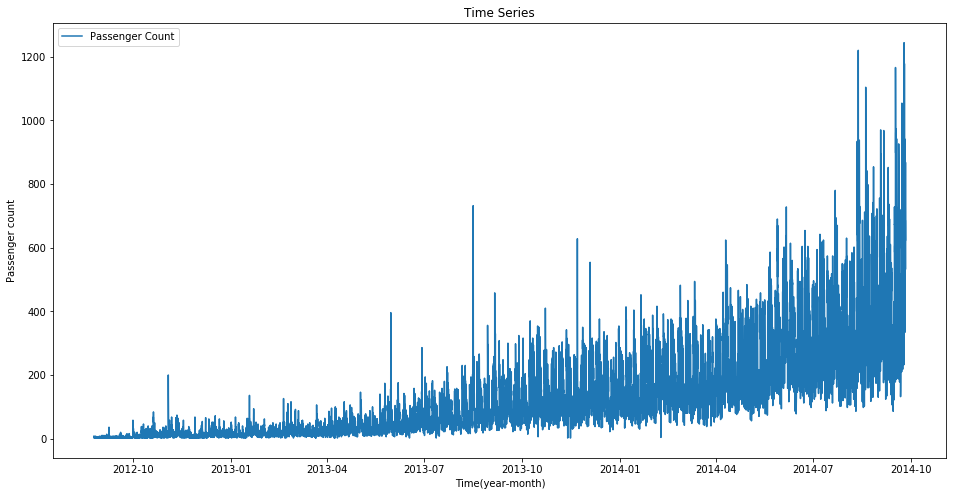

In [7]:
# look at the time series

# indexing the Datetime to get the time period on the x-axis. 
train.index = train['Datetime'] 
# drop ID variable to get only the Datetime on x-axis. 
# df = train.drop('ID',1) # 我感觉这里没有什么卵用呢

ts = train['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

5) Exploratory Analysis

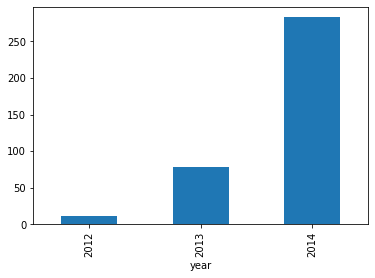

In [8]:
# first hypothesis was traffic will increase as the years pass by.
train.groupby('year')['Count'].mean().plot.bar()

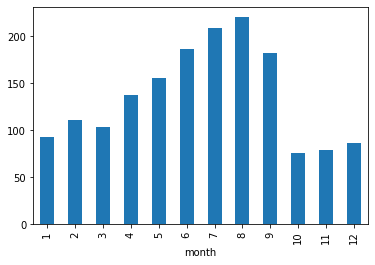

In [9]:
# second hypothesis was about increase in traffic from May to October.
train.groupby('month')['Count'].mean().plot.bar()

# 最后三个月的大幅降低是因为最后一天是2014-09-25，没有包含最后三个月

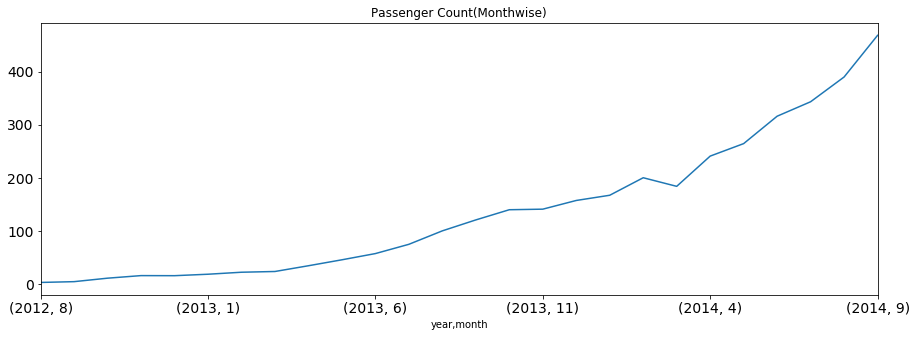

In [10]:
#  look at the monthly mean of each year separately.
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title='Passenger Count(Monthwise)', fontsize=14)

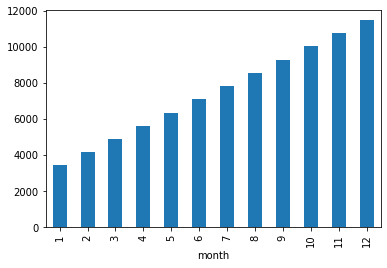

In [11]:
# 只看2013年全年的month，单调递增
train['2013-01-01':'2013-12-31'].groupby('month')['ID'].mean().plot.bar()

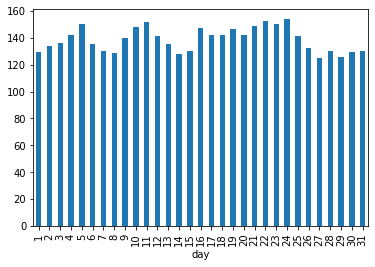

In [12]:
# look at the daily mean of passenger count.
train.groupby('day')['Count'].mean().plot.bar()
# We are not getting much insights from day wise count of the passengers.

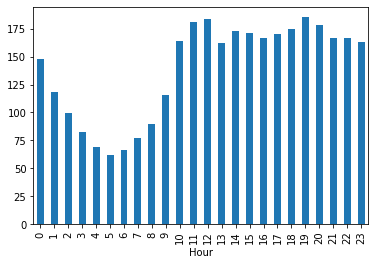

In [13]:
train.groupby('Hour')['Count'].mean().plot.bar()

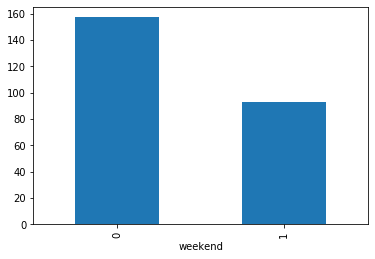

In [14]:
#  traffic is more on weekdays as compared to weekends
train.groupby('weekend')['Count'].mean().plot.bar()

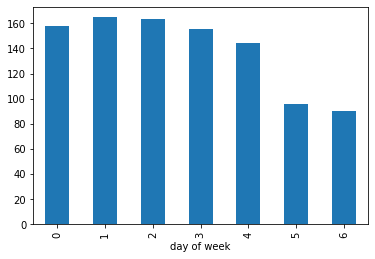

In [15]:
train.groupby('day of week')['Count'].mean().plot.bar()

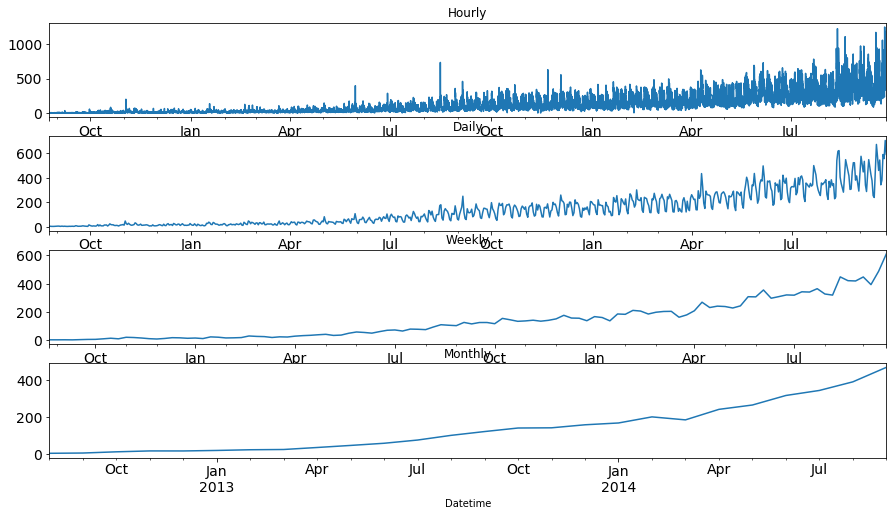

In [16]:
# aggregate the hourly time series to daily, weekly, and monthly time series 
# to reduce the noise and make it more stable 
# and hence would be easier for a model to learn

# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()
# time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

In [0]:
# we will work on the daily time series.
# train.index 在上面已经改过了
test.index = test.Datetime  

# Converting to daily mean 
test = test.resample('D').mean() 
train = train.resample('D').mean()

### Forecasting using Multiple Modeling Techniques:

1) Splitting the data into training and validation part

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data.

In [0]:
# 这个函数留着备用
def split(data, test_size=0.2):
    break_point = int(len(data) * (1 - test_size))
    train_set = data[:break_point]
    test_set = data[break_point:]
    return train_set, test_set

Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

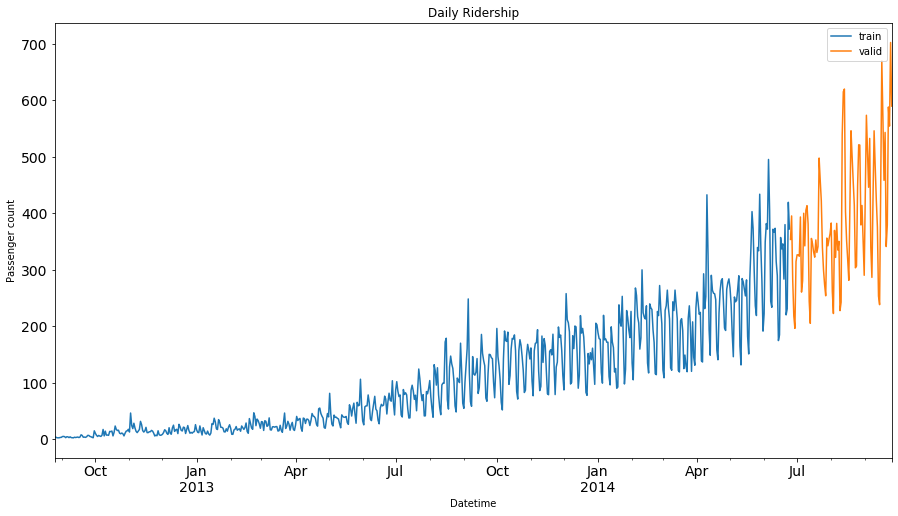

In [29]:
# Drawing plot
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best') 
plt.show()

    2) Modeling techniques
    3) Holt’s Linear Trend Model on daily time series
    4) Holt Winter’s Model on daily time series
    5) Introduction to ARIMA model
    6) Parameter tuning for ARIMA model
    7) SARIMAX model on daily time series